In [1]:
import json
import os
from pathlib import Path

import geopandas as gpd
import pandas as pd

In [2]:
data_path = Path(os.environ["DATA_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
segregation_path = Path(os.environ["SEGREGATION_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])

# Fix

In [3]:
df_census_base = (
    pd.read_csv(
        census_path / "2020" / "08.csv",
        usecols=[
            "ENTIDAD",
            "MUN",
            "LOC",
            "AGEB",
            "MZA",
            "POBTOT",
        ],
    )
    .assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
            + df["MZA"].astype(str).str.zfill(3)
        ),
    )
    .set_index("CVEGEO")
)


df_agebs = (
    gpd.read_file(
        population_grids_path
        / "final"
        / "zone_agebs"
        / "shaped"
        / "2020"
        / "08.2.03.gpkg",
    )
    .drop(columns=["POBTOT"])
    .set_index("CVEGEO")
)

df_geom_blocks = (
    gpd.read_file(geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp")
    .assign(CVEGEO_AGEB=lambda df: df["CVEGEO"].str[:13])
    .query("CVEGEO_AGEB in @df_agebs.index")
    .drop(
        columns=[
            "CVEGEO_AGEB",
            "CVE_ENT",
            "CVE_MUN",
            "CVE_LOC",
            "CVE_MZA",
            "TIPOMZA",
            "AMBITO",
            "CVE_AGEB",
        ],
    )
    .set_index("CVEGEO")
    .to_crs("EPSG:6372")
)

df_blocks = df_geom_blocks.join(df_census_base[["POBTOT"]], how="inner").fillna(0)

In [4]:
# wanted_ids = [2014, 3232, 3374]

df_neighborhoods = (
    gpd.read_file(data_path / "datos" / "colonias_raw.geojson")
    .drop(columns=["ENTIDAD", "MUNICIPIO", "CONTROL"])
    .drop_duplicates(subset=["geometry"])
    .to_crs("EPSG:6372")
    .assign(orig_area=lambda df: df["geometry"].area)
)

overlay = (
    df_neighborhoods.overlay(df_agebs.reset_index())
    .assign(area=lambda df: df["geometry"].area)
    .groupby("ID")
    .agg({"area": "sum", "orig_area": "first"})
    .assign(area_frac=lambda df: df["area"] / df["orig_area"])
    .fillna(0)
)

urban_neighborhoods = overlay[overlay["area_frac"] >= 0.10].index

df_neighborhoods = df_neighborhoods[df_neighborhoods["ID"].isin(urban_neighborhoods)]

In [5]:
self_intersections = (
    df_neighborhoods.sjoin(df_neighborhoods, how="inner", predicate="within")
    .reset_index(names="index_left")
    .query("index_left != index_right")
)

whole = df_neighborhoods[~df_neighborhoods.index.isin(self_intersections.index_left)]

In [6]:
df_neighborhoods_fixed = df_neighborhoods.copy()
for _, row in self_intersections.iterrows():
    outer = df_neighborhoods_fixed.loc[row["index_right"], "geometry"]
    inner = df_neighborhoods_fixed.loc[row["index_left"], "geometry"]
    df_neighborhoods_fixed.loc[row["index_right"], "geometry"] = outer.difference(inner)

df_neighborhoods_fixed = df_neighborhoods_fixed.set_index("ID").drop(
    columns=["orig_area"],
)

df_neighborhoods_fixed.to_crs("EPSG:4326").to_file("./colonias.geojson")

# Colonias a manzanas

In [ ]:
neighborhoods_to_blocks_map = (
    df_blocks[["geometry"]]
    .reset_index()
    .assign(orig_block_area=lambda df: df["geometry"].area)
    .overlay(
        df_neighborhoods_fixed[["geometry"]].reset_index(names="neighborhood_id"),
        how="intersection",
    )
    .assign(area_frac=lambda df: df["geometry"].area / df["orig_block_area"])
    .sort_values("area_frac", ascending=False)
    .groupby(["CVEGEO"])
    .first()
    .reset_index()
    .groupby("neighborhood_id")["CVEGEO"]
    .apply(lambda x: list(set(x)))
    .to_dict()
)

with open("./colonias_a_manzanas.json", "w") as f:
    json.dump(neighborhoods_to_blocks_map, f, indent=4)

<Axes: >

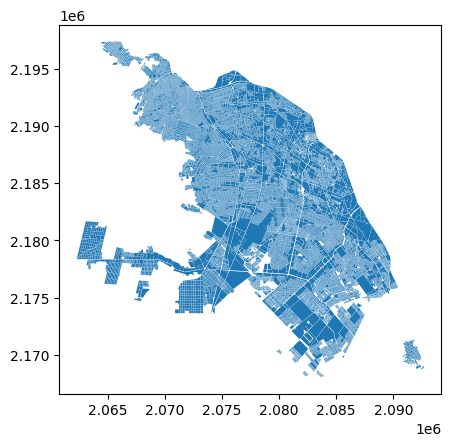

In [107]:
blocks_in_neighborhoods = list(
    set(x for l in neighborhoods_to_blocks_map.values() for x in l),
)
df_blocks.loc[blocks_in_neighborhoods].plot()